In [ ]:
%%capture
import sys
!{sys.executable} -m pip install ucimlrepo
!{sys.executable} -m pip install seaborn

from ucimlrepo import fetch_ucirepo


print("Bibliotecas importadas com sucesso!")


Inicialização dos dados:

In [32]:
# fetch dataset 
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
X = iris.data.features 
y = iris.data.targets 

# metadata
# print(iris.metadata)

# variable information
print(iris.variables)


           name     role         type demographic  \
0  sepal length  Feature   Continuous        None   
1   sepal width  Feature   Continuous        None   
2  petal length  Feature   Continuous        None   
3   petal width  Feature   Continuous        None   
4         class   Target  Categorical        None   

                                         description units missing_values  
0                                               None    cm             no  
1                                               None    cm             no  
2                                               None    cm             no  
3                                               None    cm             no  
4  class of iris plant: Iris Setosa, Iris Versico...  None             no  


In [20]:
print(X.head())
print(X.describe())
print(X.info())

y_aux = y.squeeze()
print(y_aux.unique())

   sepal length  sepal width  petal length  petal width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2
       sepal length  sepal width  petal length  petal width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column        N

Análise exploratória dos dados, plotando box-plot para cada atributo em relação as classes de Iris:

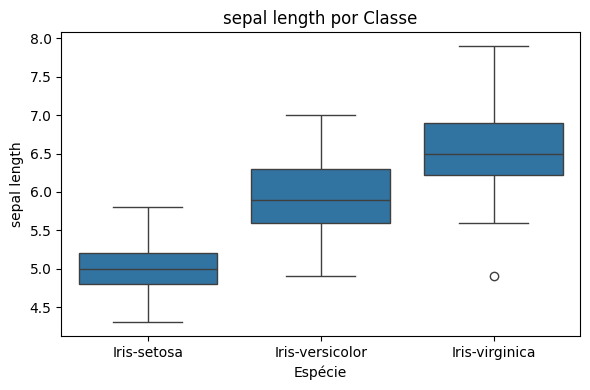

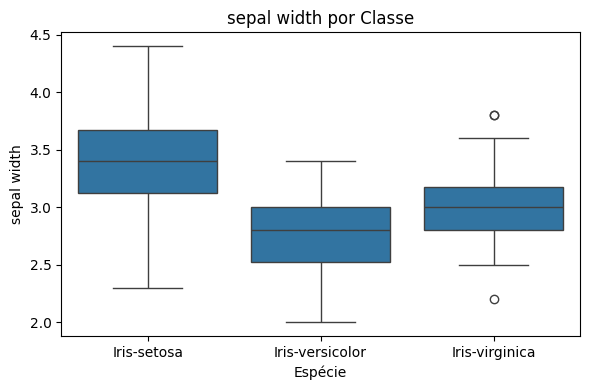

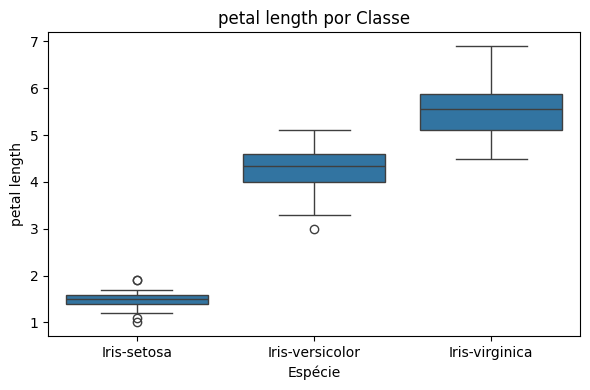

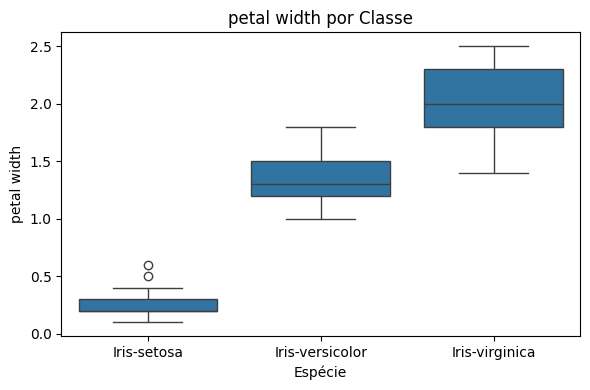

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df = X.copy()
df['target'] = y

for column in X.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='target', y=column, data=df)
    plt.title(f'{column} por Classe')
    plt.xlabel('Espécie')
    plt.ylabel(column)
  
    plt.tight_layout()
    plt.savefig(f'box_plot_{column}.png')



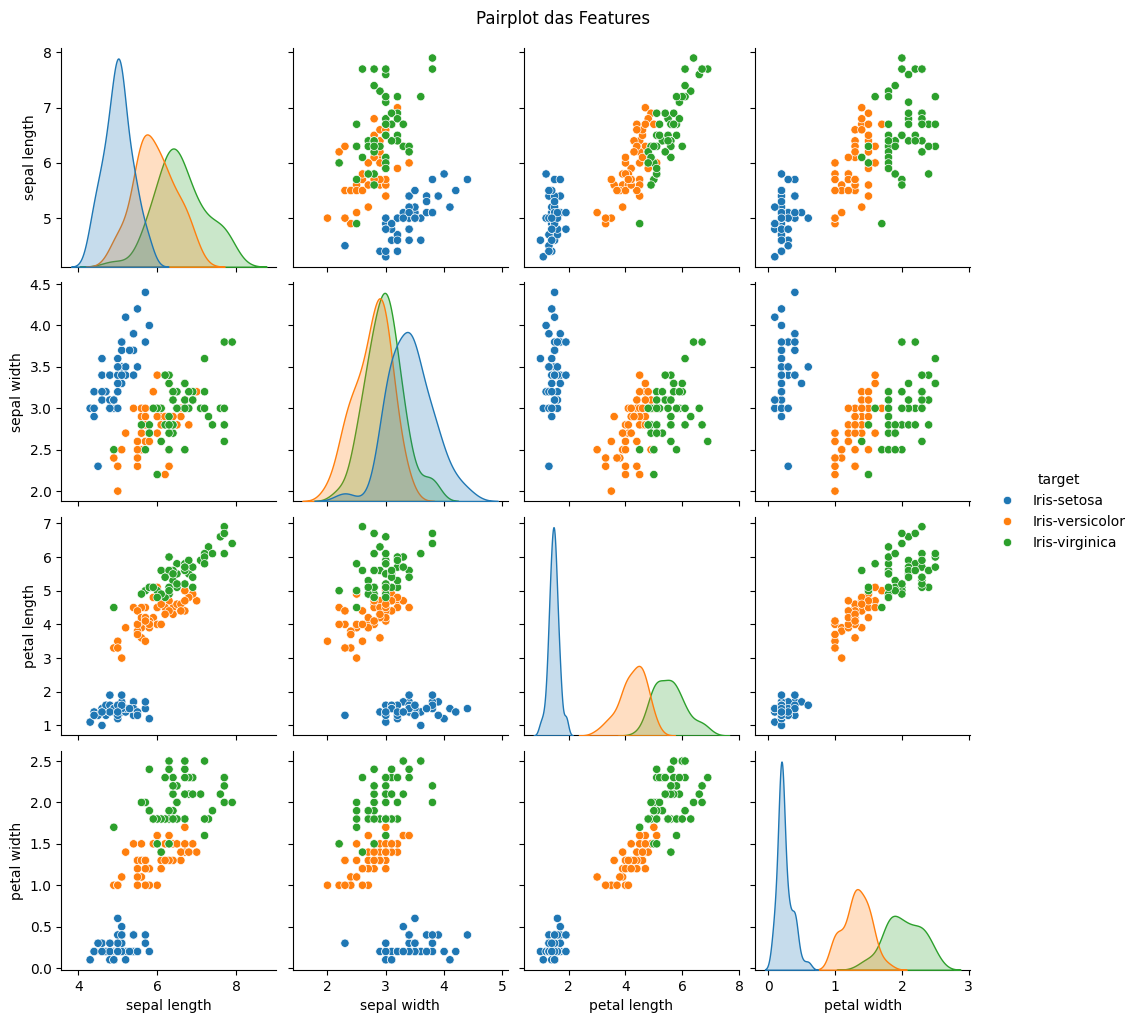

In [ ]:
sns.pairplot(df, hue='target', diag_kind='kde')
plt.suptitle("Pairplot das Features", y=1.02)
plt.savefig('pairplot.png')
plt.show()



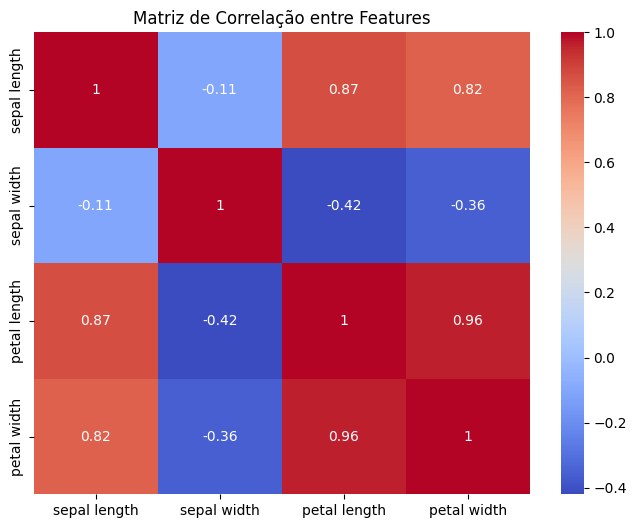

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de Correlação entre Features")
plt.savefig('correlation_matrix.png')
plt.show()


Realizada a divisão do conjunto de dados entre treino/teste, inicializando o modelo com o fit:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=37, stratify=y
)
print(f"Dimensões do conjunto de treino: {X_train.shape}")
print(f"Dimensões do conjunto de teste: {X_test.shape}")

Dimensões do conjunto de treino: (105, 4)
Dimensões do conjunto de teste: (45, 4)


In [ ]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(random_state=37)
decision_tree.fit(X_train, y_train)


DecisionTreeClassifier(random_state=37)

Primeira criação/classificação do modelo sem realizar cross validation:

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = decision_tree.predict(X_test)

print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))


Acurácia: 0.9777777777777777

Relatório de Classificação:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       1.00      0.93      0.97        15
 Iris-virginica       0.94      1.00      0.97        15

       accuracy                           0.98        45
      macro avg       0.98      0.98      0.98        45
   weighted avg       0.98      0.98      0.98        45


Matriz de Confusão:
[[15  0  0]
 [ 0 14  1]
 [ 0  0 15]]


Treinamento do modelo e teste utilizando cross validation:

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(decision_tree, X, y, cv=10)
print("Acurácia média:", scores.mean())
print("Desvio padrão:", scores.std())


Acurácia média: 0.9533333333333334
Desvio padrão: 0.04268749491621898


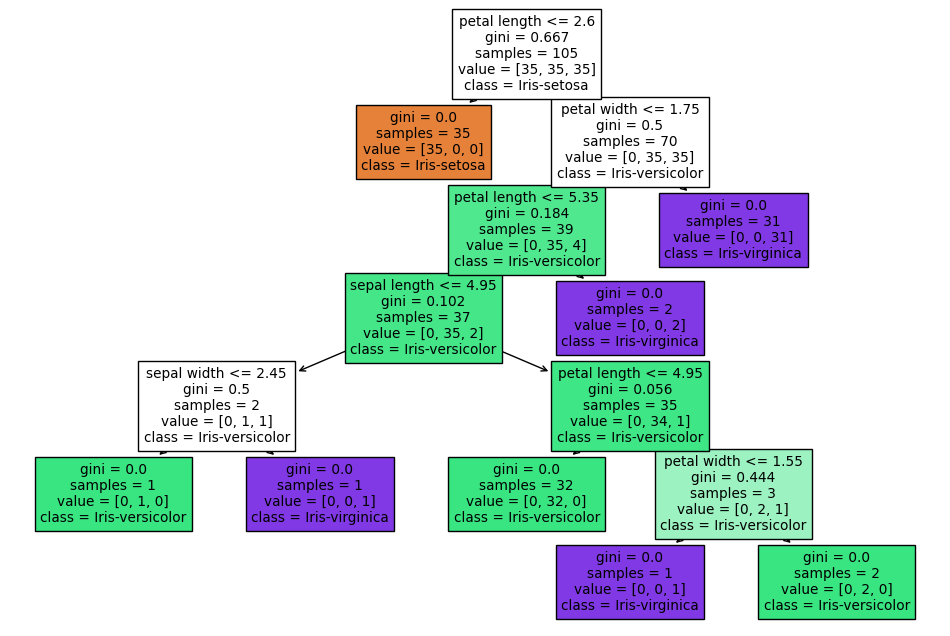

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plot_tree(decision_tree, feature_names=X.columns, class_names=decision_tree.classes_, filled=True)
plt.show()


Otimização dos hiperparâmetros, focamos apenas na altura máxima da árvore e na variação dos critérios de impureza:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

params = {
    'max_depth': [2, 3, 4, 5, None],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=37), params, cv=10)
grid.fit(X_train, y_train)

import pandas as pd

results_df = pd.DataFrame(grid.cv_results_)

results_filtered = results_df[[
    'param_max_depth', 
    'param_criterion', 
    'mean_test_score', 
    'std_test_score', 
    'rank_test_score'
]].sort_values(by='mean_test_score', ascending=False)

results_filtered.columns = ['max_depth', 'criterion', 'acuracia_media', 'desvio_padrao', 'ranking']

results_filtered.to_csv("resultados_gridsearch.csv", index=False)
print("Resultados do Grid Search salvos em 'resultados_gridsearch.csv'")

Resultados do Grid Search salvos em 'resultados_gridsearch.csv'


Dada a melhor configuração otimizada pela busca em grade, definimos então uma árvore criada com esses parâmetros e então plotamos a mesma:

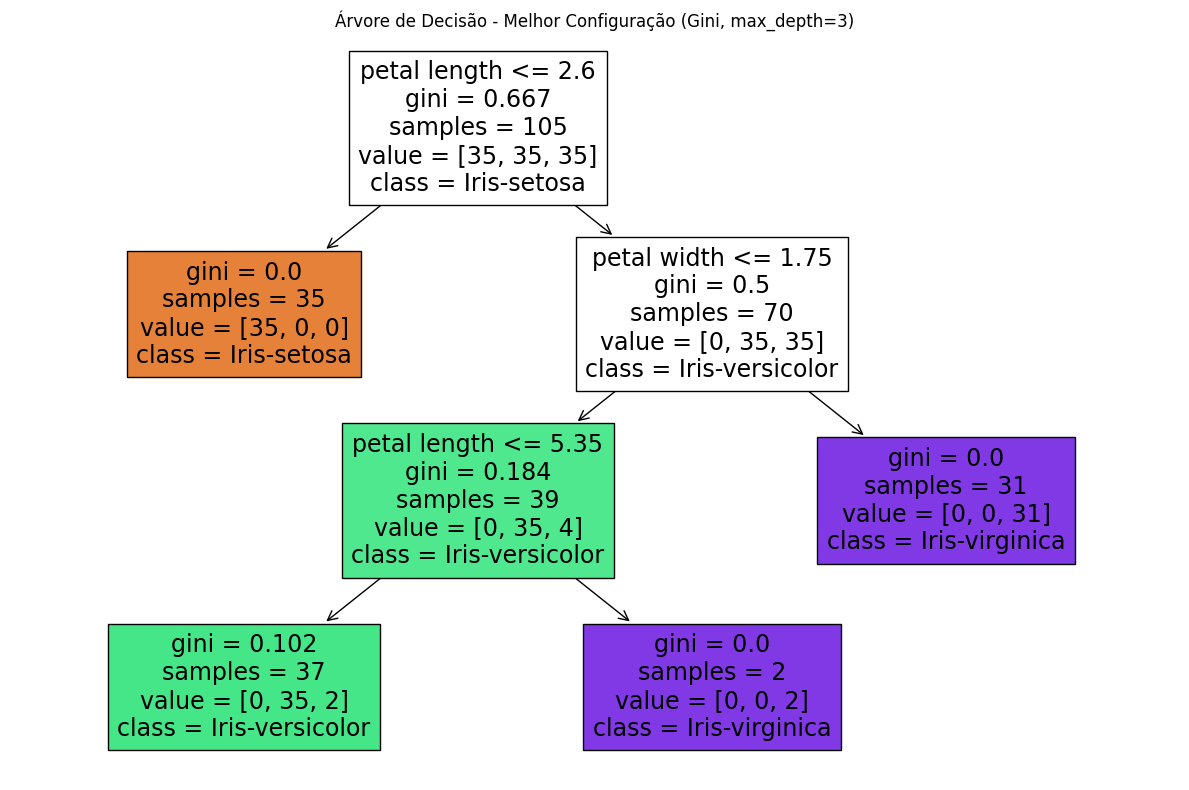

In [ ]:
best_decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=37)
best_decision_tree.fit(X_train, y_train)

plt.figure(figsize=(12, 8))
plot_tree(best_decision_tree, feature_names=X.columns, class_names=y.squeeze().unique(), filled=True)
plt.title("Árvore de Decisão - Melhor Configuração (Gini, max_depth=3)")
plt.tight_layout()
plt.savefig('best_decision_tree.png')
plt.show()